In [1]:
import pymongo
import math 
import re
import pandas as pd
import numpy as np
import pylab
from scipy import stats 

from  qgrid import show_grid as show 
from datetime import datetime

today=!(date +"%d%m%y")
today=today[0]
testname="testnight201118"
client = pymongo.MongoClient('172.16.45.8', 27017)
db = client.rapls
sensors= db["sensor"+testname]
sensors.create_index([('timestamp',pymongo.ASCENDING)])

'timestamp_1'

In [2]:
def get_times(target,source=db["testcases"+testname]):
    """convert the time stamps from int to datetame """
    x= list(db["testcases"+testname].find({'name':target}))[0]
    x['execution']=datetime.utcfromtimestamp(int(x['execution']))
    x['begin']=datetime.utcfromtimestamp(int(x['begin']))
    x['end']=datetime.utcfromtimestamp(int(x['end']))
    x['warmup']=datetime.utcfromtimestamp(int(x['warmup']))
    return x 

def calculate_power(times,source=sensors):
    """need a time object from get_times function and return 2 dataframes  """
    cursor =sensors.find({'target':'system','timestamp' :{'$gte':times['begin'],'$lte':times['end']}},{"_id":0,"timestamp":"timestamp","rapl.0.38.RAPL_ENERGY_PKG":"rapls"})
    results=pd.DataFrame(list(cursor),columns=['timestamp',"rapl"])
    results["rapl"]=results["rapl"].apply(lambda row :math.ldexp( row['0']['38']['RAPL_ENERGY_PKG'],-32))
    warmup=results[(results["timestamp"]<=times["execution"]) & (results["timestamp"]>times["warmup"] )]
    execution = results[(results["timestamp"]>times["execution"]) ]
    return warmup , execution

def calculate_energy(times,source=sensors) : 
    """need a times object from get_times """
    warmup,execution =calculate_power(times)
    return   warmup["rapl"].sum() , execution["rapl"].sum()

def get_recap(target):
    """require a row from the database and not a times object"""
    times=get_times(target['name'])
    energy=calculate_energy(times)
    return {'name': target['name'] 
            ,'warmup time': (int(target['execution'])-int(target['warmup'])) 
            ,'warmup energy': energy[0] 
            ,'execution time': (int(target['end'])-int(target['execution']) )
            ,'execution energy': energy[1]
           }

def correction(self): 
    low = 0.25
    high = 0.75
    q1,q3 = self.quantile([low, high])
    iqr=q3-q1
    inf,sup = q1-1.5*iqr,q3+1.5*iqr
    return self[(self >inf )  & (self  < sup) ].dropna()

def correction2(self,measure="execution energy"): 
    low = 0.25
    high = 0.75
    q1,q3 = self[measure].quantile([low, high])
    iqr=q3-q1
    inf,sup = q1-1.5*iqr,q3+1.5*iqr
    return self[(self[measure] >inf )  & (self[measure]  < sup) ].dropna()


pd.Series.correct=correction 
pd.DataFrame.correct=correction2 



In [86]:
regx = re.compile(".*int10.*", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
show(times)
# data = pd.DataFrame(columns=['name','warmup time','warmup energy','execution time ','execution energy']) 
data=[]
times.apply(lambda row: data.append(get_recap(row)), axis=1)
    
data=pd.DataFrame.from_dict(data)
# show(data)

In [87]:
data["implementation"]= data["name"].apply(lambda name:re.search('tommtiv1(?P<name>.*)int10n', name).group(1))
mystats=data.groupby("implementation")
# mystats=mystats.apply(lambda x : x.correct())
mystats=mystats.mean()
mystats=mystats.sort_values("execution energy",ascending=False)
show(mystats)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Text(0.5,0,'energy(j)')

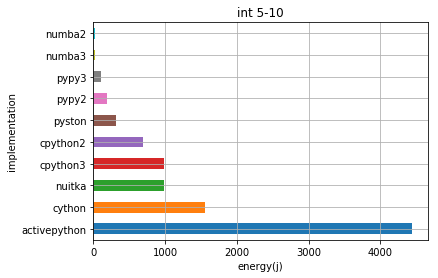

In [61]:
mystats['execution energy'].plot(kind='barh',grid=True,sort_columns=True,title="int 5-10").set_xlabel("energy(j)")

In [79]:
regx = re.compile(".*cpython2int5n.*", re.IGNORECASE)
times1=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
# data1 = pd.DataFrame(columns=['name','warmup time','warmup energy','execution time ','execution energy']) 
data1=[]
times1.apply(lambda row: data1.append(get_recap(row)), axis=1)
    
data1=pd.DataFrame.from_dict(data1)
show(data1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

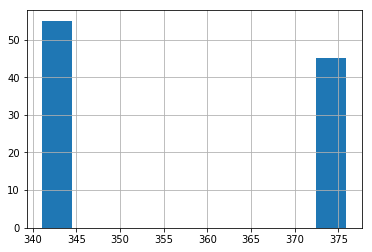

In [80]:
y.hist()

moyenne:  356.9194671630859 
mediane : 341.7070617675781


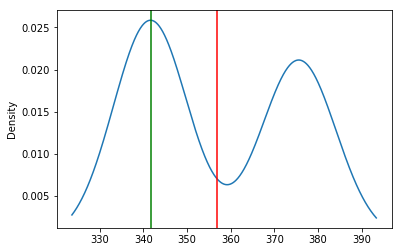

In [78]:
measure='execution energy'
y= data1[measure]
std=data1[measure].std()

# med = data1[measure].med()
# print(mean,std)
# y1=y[(y > mean - mean*2*std ) & (y < mean + 2*std)]

# y.plot.kde(bw_method=0.5)
# y1.plot.kde()
# plt=y2.plot.kde(bw_method=0.5)
# plt.legend(["y","y1","y2"])
# plt.axvline(x=inf)
# plt.axvline(x=sup)
plt=y.plot.kde(bw_method=.5)
plt.axvline(x=y.mean(),color="red")
plt.axvline(x=y.median(),color="green")

print("moyenne: ",y.correct().mean(),"\nmediane :",y.correct().median())

NameError: name 'y1' is not defined

In [171]:
z=data1[measure].correct()

mean = z.mean()
std= z.std()
z["standar"+measure]=z.apply(lambda x:(x-mean)/std)
# show(z)
zc= z["standar"+measure]
# zc

# zc=z.correct()
# pylab.violinplot(z.correct(),showmeans=True)
zc.mean()

-3.6271160595083647e-16